# Data Analysis

In [1]:
import pandas as pd 
import glob
import re
import sys
import concurrent.futures
from Analysis import Analysis
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)

### Calculate the result for each bug

In [2]:
root = "/home/jovyan/work"
analyzer = Analysis(root)

projects = [
    "Time", "JacksonXml", "Collections", "Compress", "Csv", "JacksonCore", "JacksonDatabind", 
    "Jsoup", "Lang", "Math", "Gson", "Closure", "Mockito"
]
future_results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    for project in projects:
        # FOR EACH BUG
        for bug_path in glob.glob("{root}/results/{project}/Bug_*/".format(root=root, project=project)):
            bug = re.search(r"Bug_(\d+)", bug_path).group(1)
            try:
                future = executor.submit(analyzer.analyzeBug, project, bug, False)
                future_results.append(future)
            except Exception as e:
                print(bug_path)
                print(e)

In [3]:
bug_results = []
for future in future_results:
    r = future.result() 
    bug_results.append(r)

### Example of bug result when a BIC detected

In [4]:
bug_results[3]

{'id': 'Time_Bug_1',
 'bug': 'Bug_1',
 'project': 'Time',
 'fix_pass': True,
 'prev_fails': True,
 'category': 'A regression is detected',
 'sub_category': 'Unique candidates',
 'test_name': 'org.joda.time.TestPartial_Constructors#testConstructorEx7_TypeArray_intArray',
 'bug_report': 'https://github.com/JodaOrg/joda-time/issues/93',
 'fix_commit': '9a62b06be5d0df8e833ff8583398cca386608cac',
 'BIC_candidates': [[1, '8612f9e5b88c1bea933ef9ab1e431f5db3006b48']],
 'bic_position': 1,
 'bic_age': 0,
 'executionsOnPast': 151,
 'buildFail': 0,
 'buildTestFail': 1493,
 'numCommits': 1717,
 'transplantability_days': 931,
 'transplantability_position': 223}

In [5]:
resume_df= pd.DataFrame(bug_results)[
    ['id', 'project','executionsOnPast', 'numCommits',
     'buildFail', 'buildTestFail', 'BIC_candidates', 'transplantability_days', 'transplantability_position']
]

# Remove bugs with non-succeed BFC
resume_df = resume_df[resume_df['numCommits'] > 1]

resume_df['one_bic_found'] = resume_df.apply (
    lambda row: 1 if len(row['BIC_candidates']) == 1 else 0, axis=1
)
resume_df['n_bic_found'] = resume_df.apply (
    lambda row: 1 if len(row['BIC_candidates']) > 1 else 0, axis=1
)
resume_df['executionsOnPast_rate'] = resume_df.apply (
    lambda row: row['executionsOnPast'] * 100 / row['numCommits'], axis=1
)
resume_df['compilability'] = resume_df.apply (
    lambda row: (row['numCommits']-row['buildFail']) * 100 / row['numCommits'], axis=1
)
resume_df['testCompilability'] = resume_df.apply (
    lambda row: (row['numCommits']-row['buildTestFail']-row['buildFail']) * 100 / row['numCommits'], axis=1
)

## RQ1A: “How far can a test be transplanted into the past”

In [6]:
resume_df.groupby('project').agg(
    bugs=('project','size'), 
    transplantability_days_mean=('transplantability_days','mean'),
    transplantability_days_median=('transplantability_days','median'),
    transplantability_position_mean=('transplantability_position','mean'),
    transplantability_position_median=('transplantability_position','median')
).round(0).astype(int)

,bugs,transplantability_days_mean,transplantability_days_median,transplantability_position_mean,transplantability_position_median
project,,,,,
Closure,147,248,101,482,174
Collections,2,495,495,144,144
Compress,47,1863,2021,1208,1326
Csv,15,85,36,39,24
Gson,18,1284,1212,481,368
JacksonCore,23,416,459,253,261
JacksonDatabind,97,708,654,1184,1094
JacksonXml,3,1365,1408,429,407
Jsoup,91,438,240,144,76


In [7]:
t_days = resume_df['transplantability_days']
t_position = resume_df['transplantability_position']
print("Transplantability in days (Mean/Median): %d %d"%(t_days.mean(), t_days.median()))
print("Transplantability in # commits (Mean/Median): %d %d"%(t_position.mean(), t_position.median()))

Transplantability in days (Mean/Median): 574 272
Transplantability in # commits (Mean/Median): 578 227


,count,mean,std,min,25%,50%,75%,max
transplantability_days,672,574,732,0,77,272,766,3475
transplantability_position,672,578,727,0,78,227,858,3709


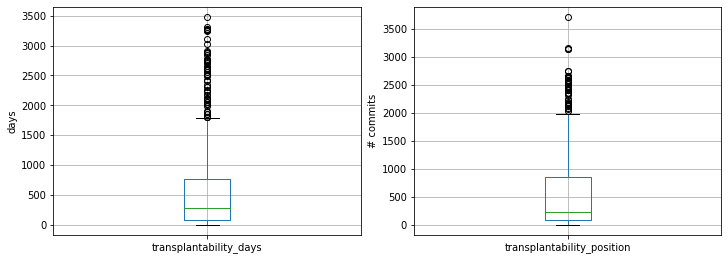

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 3.5), layout="constrained")

resume_df.boxplot(column='transplantability_days', ax=axs[0])
axs[0].set_ylabel("days")

resume_df.boxplot(column='transplantability_position', ax=axs[1])
axs[1].set_ylabel("# commits")

resume_df[['transplantability_days', 'transplantability_position']].describe().astype(int).T

In [9]:
regressions_df = pd.DataFrame(bug_results)[
    ['id', 'project','category', 'sub_category', 'bic_position', 'bic_age']
]
regressions_df = regressions_df[regressions_df['sub_category']=='Unique candidates']
bic_position = regressions_df['bic_position']
bic_age = regressions_df['bic_age']
print("BIC position (Mean/Median): %d %d"%(bic_position.mean(), bic_position.median()))
print("BIC age (Mean/Median): %d %d"%(bic_age.mean(), bic_age.median()))
regressions_df

BIC position (Mean/Median): 152 41
BIC age (Mean/Median): 165 36


,id,project,category,sub_category,bic_position,bic_age
3,Time_Bug_1,Time,A regression is detected,Unique candidates,1.0,0.0
37,Compress_Bug_28,Compress,A regression is detected,Unique candidates,273.0,261.0
72,Compress_Bug_45,Compress,A regression is detected,Unique candidates,1.0,0.0
106,JacksonCore_Bug_11,JacksonCore,A regression is detected,Unique candidates,162.0,215.0
115,JacksonCore_Bug_10,JacksonCore,A regression is detected,Unique candidates,99.0,123.0
118,JacksonCore_Bug_21,JacksonCore,A regression is detected,Unique candidates,296.0,429.0
154,JacksonDatabind_Bug_24,JacksonDatabind,A regression is detected,Unique candidates,101.0,55.0
172,JacksonDatabind_Bug_35,JacksonDatabind,A regression is detected,Unique candidates,131.0,343.0
180,JacksonDatabind_Bug_41,JacksonDatabind,A regression is detected,Unique candidates,32.0,10.0
201,JacksonDatabind_Bug_87,JacksonDatabind,A regression is detected,Unique candidates,5.0,3.0


## RQ1B: “What aspects prevent us from transplanting the test to the past?”

In [10]:
resume_df.groupby('project').agg(
    bugs=('project','size'), 
    #s_bics=('one_bic_found','sum'),
    #m_bics=('n_bic_found','sum'),
    compilability_mean=('compilability','mean'), 
    compilability_median=('compilability','median'),
    test_compilability_mean=('testCompilability','mean'), 
    test_compilability_median=('testCompilability','median'),
    ratio_mean=('executionsOnPast_rate','mean'), 
    ratio_median=('executionsOnPast_rate','median'),
).round(0)
compilability = resume_df['compilability']
t_compilability = resume_df['testCompilability']
t_runnability = resume_df['executionsOnPast_rate']
print("Src Compilability (Mean/Median): %.2f %.2f"%(compilability.mean(), compilability.median()))
print("Test Compilability (Mean/Median): %.2f %.2f"%(t_compilability.mean(), t_compilability.median()))
print("Test runability (Mean/Median): %.2f %.2f"%(t_runnability.mean(), t_runnability.median()))

Src Compilability (Mean/Median): 52.18 47.34
Test Compilability (Mean/Median): 20.00 12.01
Test runability (Mean/Median): 19.76 11.41


## RQ2: “Can the BIC for a given bug be found using its regression test?”

### Summary of results

In [11]:
df = pd.DataFrame(bug_results)[['id', 'project','category', 'sub_category']]
df[df['category'] != None].set_index('id').sort_index()
print(len(df))
df['category'].value_counts()

730


No regression is detected       595
A regression is detected         77
Test fails in the fix commit     58
Name: category, dtype: int64

### Results per sub-catergory

In [12]:
df.groupby(['category', "sub_category"]).count()['id']

category                      sub_category             
A regression is detected      Multiple candidates           27
                              Unique candidates             50
No regression is detected     -                            595
Test fails in the fix commit  Failure in source build       53
                              Failure in test build          2
                              Test execution fails           2
                              The test was not executed      1
Name: id, dtype: int64

In [13]:
df[df['sub_category']=='Unique candidates']

,id,project,category,sub_category
3,Time_Bug_1,Time,A regression is detected,Unique candidates
37,Compress_Bug_28,Compress,A regression is detected,Unique candidates
72,Compress_Bug_45,Compress,A regression is detected,Unique candidates
106,JacksonCore_Bug_11,JacksonCore,A regression is detected,Unique candidates
115,JacksonCore_Bug_10,JacksonCore,A regression is detected,Unique candidates
118,JacksonCore_Bug_21,JacksonCore,A regression is detected,Unique candidates
154,JacksonDatabind_Bug_24,JacksonDatabind,A regression is detected,Unique candidates
172,JacksonDatabind_Bug_35,JacksonDatabind,A regression is detected,Unique candidates
180,JacksonDatabind_Bug_41,JacksonDatabind,A regression is detected,Unique candidates
201,JacksonDatabind_Bug_87,JacksonDatabind,A regression is detected,Unique candidates


### Test execution fails (FIX COMMIT)

In [14]:
df[df['sub_category']=='Test execution fails']

,id,project,category,sub_category
239,Jsoup_Bug_67,Jsoup,Test fails in the fix commit,Test execution fails
316,Jsoup_Bug_78,Jsoup,Test fails in the fix commit,Test execution fails


- Jsoup 67 -> Test depends of execution time (flaky)
- Jsoup 78 -> Test has a Timeout

### Failure in test build (FIX COMMIT)

In [15]:
df[df['sub_category']=='Failure in test build']

,id,project,category,sub_category
35,Collections_Bug_27,Collections,Test fails in the fix commit,Failure in test build
92,Csv_Bug_13,Csv,Test fails in the fix commit,Failure in test build


- Collections 27 -> Other tests doesn't compile
- Csv 13 -> Library "lang" doesn't exists

### Failure in source build (FIX COMMIT)

In [16]:
df[df['sub_category']=='Failure in source build']

,id,project,category,sub_category
13,Time_Bug_26,Time,Test fails in the fix commit,Failure in source build
22,Time_Bug_25,Time,Test fails in the fix commit,Failure in source build
26,JacksonXml_Bug_1,JacksonXml,Test fails in the fix commit,Failure in source build
27,JacksonXml_Bug_6,JacksonXml,Test fails in the fix commit,Failure in source build
31,JacksonXml_Bug_5,JacksonXml,Test fails in the fix commit,Failure in source build
101,JacksonCore_Bug_23,JacksonCore,Test fails in the fix commit,Failure in source build
104,JacksonCore_Bug_24,JacksonCore,Test fails in the fix commit,Failure in source build
112,JacksonCore_Bug_26,JacksonCore,Test fails in the fix commit,Failure in source build
141,JacksonDatabind_Bug_76,JacksonDatabind,Test fails in the fix commit,Failure in source build
155,JacksonDatabind_Bug_104,JacksonDatabind,Test fails in the fix commit,Failure in source build
